# 1️⃣ **Описание шаблона для решения задачи.**

**Задача**: обучить несколько бустингов на 3-х фолдах, выбрать лучшие, усреднить предсказания.

**Модели, которые будем обучать:**
- `CatBoostRegressor`
- `LightGBMRegressor (goss)`
- `XGBoostRegressor (dart)`


✅ Будут выполнены:
- все дополнительные условия
- возможности фреймворков (загрузка датасетов с помощью соответствующих классов, правильная подготовка категориальных признаков, early_stopping, многопоточность)
- подбор гиперпараметров для каждой модели

👀 При желании, рекомендуется проделать следующее:
- Провести EDA (Exploratory Data Analysis) и сделать выводы на основе графики
- Провести Feature Selection
- Провести Object Selection
- Использовать scheduler или custom callbacks
- Обучить дополнительные модели


❗️❗️❗️ **P.S.**
- Данный ноутбук - далеко не единственное верное решение, воспринимайте его как помощник для вашего собственного решения или чтобы побороть страх белого листа :)

- При полном заполнении ноутбука можно получить максимум 9 баллов из 10, так как из дополнительных баллов - только балл за подбор гиперпараметров.

- При любых найденных ошибках/опечатках/непонятных моментов в коде, пишите в [чат курса](https://stepik.org/lesson/681941/step/6?unit=680724)

# 2️⃣ **Подключение необходимых библиотек и загрузка данных.**

In [1]:
!pip install catboost lightgbm xgboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostRegressor, Pool, CatBoostClassifier

import lightgbm as lgb
from lightgbm import Dataset, LGBMRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv')

In [4]:
RANDOM_STATE = 123

In [5]:
results = [] # Здесь будем хранить информацию по каждой модели

# 3️⃣ **Определим вспомогательные функции.**

In [6]:
def train_model(algorithm,
                X,
                y,
                early_stopping_rounds,
                init_params=None,
                cat_features=None,
                random_seed=2023
    ):
    scores = []
    models = []

    kf = KFold(n_splits=3, shuffle=True, random_state=random_seed)

    print(f"========= TRAINING {algorithm.__name__} =========")

    for num_fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_eval = X.iloc[train_index], X.iloc[val_index]
        y_train, y_eval = y.iloc[train_index], y.iloc[val_index]

        if init_params is not None:
            model = algorithm(**init_params)
        else:
            model = algorithm()

        if algorithm.__name__ == 'CatBoostRegressor':
            # Используйте соответствующий класс
            train_dataset = Pool(data=X_train,
                                 label=y_train,
                                 cat_features=cat_features)
            eval_dataset = Pool(data=X_eval,
                                 label=y_eval,
                                 cat_features=cat_features)

            model.fit(train_dataset,
                      eval_set=eval_dataset,
                      verbose=0,
                      early_stopping_rounds=early_stopping_rounds)


        elif algorithm.__name__ == 'LGBMRegressor':
            # Используйте соответствующий класс
            train_dataset = Dataset(data=X_train,
                                    label=y_train,
                                    categorical_feature=cat_features)
            eval_dataset = Dataset(data=X_eval,
                                    label=y_eval,
                                    categorical_feature=cat_features)

            model = lgb.train(params=init_params,
                              train_set=train_dataset,
                              valid_sets=(eval_dataset),
                              categorical_feature=cat_features,
                              )#verbose_eval=False)

        elif algorithm.__name__ == 'XGBRegressor':
            # Используйте соответствующий класс
            train_dataset = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
            eval_dataset = xgb.DMatrix(data=X_eval, label=y_eval, enable_categorical=True)

            model = xgb.train(params=init_params,
                              dtrain=train_dataset,
                              evals=[(train_dataset, 'dtrain'), (eval_dataset, 'dtest')],
                              verbose_eval=False,
                              early_stopping_rounds=early_stopping_rounds)
            X_eval = eval_dataset

        # Сделайте предсказание на X_eval и посчитайте RMSE
        y_pred = model.predict(X_eval)
        score = np.sqrt(mean_squared_error(y_eval, y_pred))

        models.append(model)
        scores.append(score)

        print(f'FOLD {num_fold}: SCORE {score}')

    mean_kfold_score = np.mean(scores, dtype="float16") -  np.std(scores, dtype="float16")
    print("\nMEAN RMSE SCORE", mean_kfold_score)

    # Выберите модель с наименьшим значением скора
    best_model_ind = np.argmin(scores)
    best_model = models[best_model_ind]

    return mean_kfold_score, best_model

In [7]:
from tqdm import tqdm

In [8]:
def tuning_hyperparams(algorithm,
                       X,
                       y,
                       init_params,
                       fit_params,
                       grid_params,
                       n_iter,
                       cv=3,
                       random_state=2023,
    ):
    # progress_bar = tqdm(total=n_iter, desc='Tuning Progress')

    estimator = algorithm(**init_params)

    # Можно использоавть GridSearchCV
    model = RandomizedSearchCV(estimator=estimator,
                               param_distributions=grid_params,
                               n_iter=n_iter,
                               cv=cv,
                               scoring='neg_root_mean_squared_error',
                               n_jobs=-1,
                               verbose=1,
                               random_state=random_state
    )

    model.fit(X, y, **fit_params)

    # progress_bar.close()

    return model.best_params_ | init_params

# Немного Fearure Selection

In [9]:
!pip install phik -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 14.1 MB/s eta 0:00:00


In [10]:
import phik
from phik.report import plot_correlation_matrix
from phik import report
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
train.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


In [12]:
train.isnull().sum()

car_id                      0
model                       0
car_type                    0
fuel_type                   0
car_rating                  0
year_to_start               0
riders                      0
year_to_work                0
target_reg                  0
target_class                0
mean_rating                 0
distance_sum                0
rating_min                  0
speed_max                   0
user_ride_quality_median    0
deviation_normal_count      0
user_uniq                   0
dtype: int64

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']


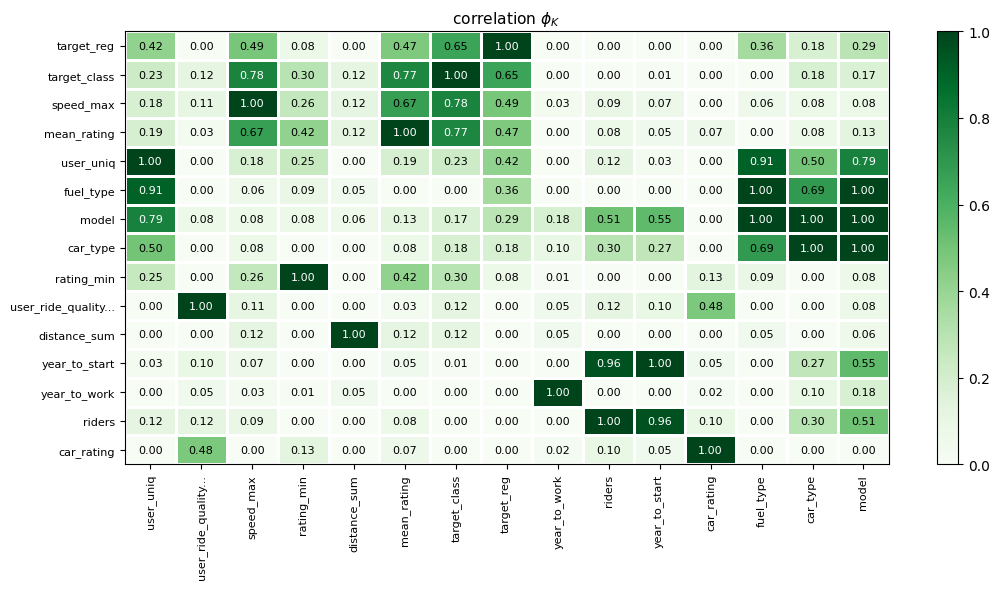

In [13]:
phik_overview = train.drop(['car_id'], axis=1).phik_matrix().round(2).sort_values(['target_reg', 'target_class'])

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

In [14]:
# Здесь кажутся подозрительными year_to_work(0, 0), riders(0, 0), year_to_start(0, 0.01), car_rating(0, 0)

In [15]:
cat_features = ['model', 'car_type', 'fuel_type']
targets = ['target_calss', 'traget_reg']
drop_cols=['car_id', 'target_class', 'target_reg']

In [16]:
X = train.drop(drop_cols, axis=1, errors = 'ignore')
y = train['target_class'].fillna(0)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_features,
                           thread_count=-1)
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=100, plot=False,
          early_stopping_rounds=100)

Learning rate set to 0.109335
0:	learn: 1.8108068	test: 1.8310378	best: 1.8310378 (0)	total: 272ms	remaining: 4m 31s
100:	learn: 0.3973528	test: 0.5476426	best: 0.5476426 (100)	total: 16.1s	remaining: 2m 23s
200:	learn: 0.2789378	test: 0.5441162	best: 0.5374049 (156)	total: 30.3s	remaining: 2m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5374048663
bestIteration = 156

Shrink model to first 157 iterations.


In [19]:
fi = model.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,speed_max,35.498503
1,mean_rating,34.897253
2,rating_min,13.734211
3,model,3.724034
4,user_uniq,3.199956
5,car_type,2.693777
6,user_ride_quality_median,1.518528
7,car_rating,1.248953
8,distance_sum,1.212690
9,riders,1.095000


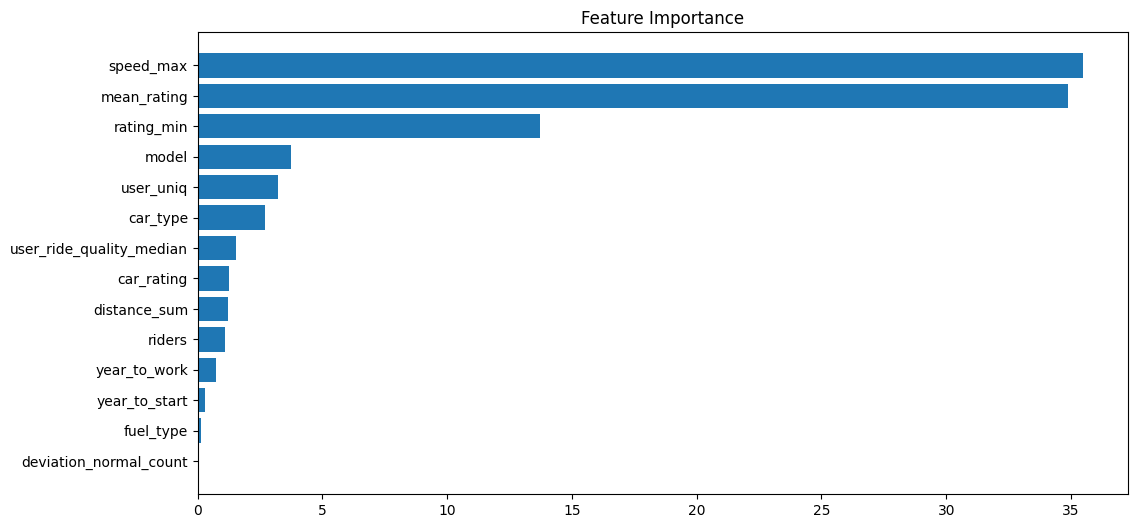

In [20]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

In [21]:
# Здесь кажутся подозрительными devitation_normal_count, fuel_type, year_to_start

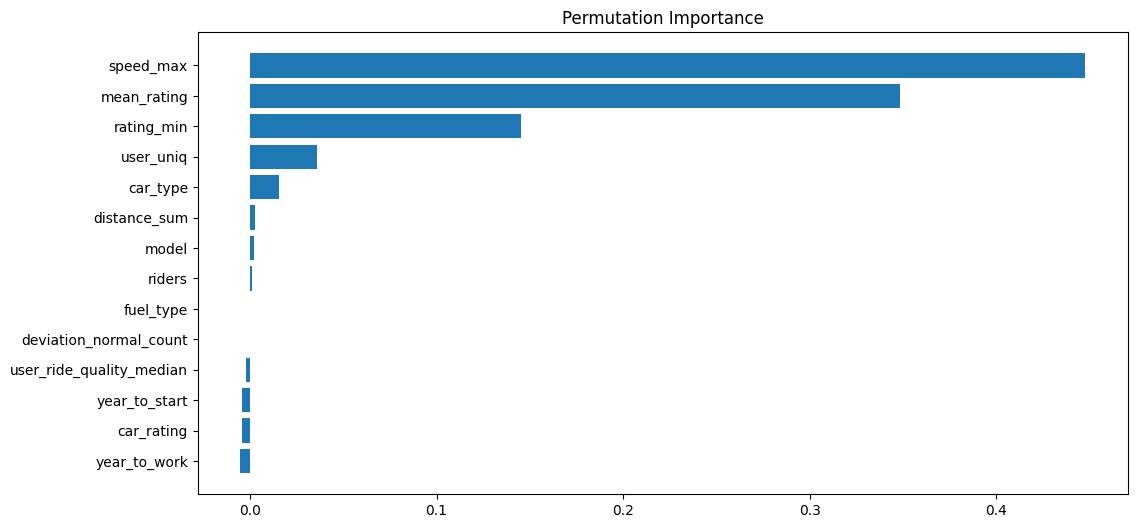

In [22]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

In [23]:
# Здесь подозрительные year_to_work, car_rating, year_to_start, user_ride_quality_median, deviation_normal_count, fuel_type

In [24]:
# кажутся подозрительными year_to_work(0, 0), riders(0, 0), year_to_start(0, 0.01), car_rating(0, 0)
# кажутся подозрительными deviation_normal_count, fuel_type, year_to_start
# кажутся подозрительные year_to_work, car_rating, year_to_start, user_ride_quality_median, deviation_normal_count, fuel_type

In [25]:
strange_cols = ['year_to_work', 'riders', 'year_to_start', 'deviation_normal_count', 'fuel_type', 'car_rating']

# 4️⃣ **Группируем признаки, отбираем категориальные, выделяем датасет для обучения.**

In [26]:
train.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


In [27]:
features2drop = ['car_id', 'target_class', 'target_reg']

filtered_features = train.drop(features2drop, axis=1).columns # Пока будем пользоваться всеми колонками, но потом попробуем повыбрасывать подозрительные
num_features = train.drop(cat_features + features2drop, axis=1).columns


print("cat_features", cat_features)
print("num_features", num_features)
print("targets", targets)

cat_features ['model', 'car_type', 'fuel_type']
num_features Index(['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating',
       'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median',
       'deviation_normal_count', 'user_uniq'],
      dtype='object')
targets ['target_calss', 'traget_reg']


In [28]:
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_reg"]

# 5️⃣ **CatBoostRegressor.**



## **Обучение модели.**

In [29]:
from itertools import combinations

def select_best_model_with_discarded_columns(discarded_columns, X, y, cat_features, **train_params):
    best_score = float('inf')
    best_model = None
    best_discarded_columns = None

    for r in range(1, len(discarded_columns) + 1):
        for discarded_columns_combination in combinations(discarded_columns, r):
            X_filtered = X.drop(columns=list(discarded_columns_combination), axis=1, errors="ignore")
            cat_features_filtered = [cat_feat for cat_feat in cat_features if cat_feat not in discarded_columns_combination]
            score, model = train_model(X=X_filtered, y=y, **train_params, cat_features=cat_features_filtered)

            if score < best_score:
                best_score = score
                best_model = model
                best_discarded_columns = discarded_columns_combination

    return best_score, best_model, best_discarded_columns


In [30]:
strange_cols

['year_to_work',
 'riders',
 'year_to_start',
 'deviation_normal_count',
 'fuel_type',
 'car_rating']

In [31]:
X.columns

Index(['model', 'car_type', 'fuel_type', 'car_rating', 'year_to_start',
       'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min',
       'speed_max', 'user_ride_quality_median', 'deviation_normal_count',
       'user_uniq'],
      dtype='object')

In [32]:
cb_init_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'thread_count': -1,
    'task_type': 'CPU',
    'random_seed': RANDOM_STATE
}

cb_score, cb_model, best_discarded_columns = select_best_model_with_discarded_columns(
    discarded_columns=strange_cols,
    algorithm=CatBoostRegressor,
    X=X, y=y,
    init_params=cb_init_params,
    early_stopping_rounds=50,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 11.705200659946849
FOLD 1: SCORE 11.657585583056068
FOLD 2: SCORE 11.330840169846462

MEAN RMSE SCORE 11.4
========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 11.721391933782762
FOLD 1: SCORE 11.614610980056382
FOLD 2: SCORE 11.351662196913995

MEAN RMSE SCORE 11.41
========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 11.715768996789826
FOLD 1: SCORE 11.591565569141883
FOLD 2: SCORE 11.385619302720418

MEAN RMSE SCORE 11.43
========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 11.74099128893579
FOLD 1: SCORE 11.641029341102675
FOLD 2: SCORE 11.296576797597965

MEAN RMSE SCORE 11.375
========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 11.786368577611805
FOLD 1: SCORE 11.660268909110366
FOLD 2: SCORE 11.359418897113242

MEAN RMSE SCORE 11.42
========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 11.667059880542267
FOLD 1: SCORE 11.652997647787148
FOLD 2: SCORE 11.370819552816577

MEAN RMSE

In [33]:
print(cb_score, cb_model, best_discarded_columns) # Мы получили колонки на которых скор лучше

11.31 <catboost.core.CatBoostRegressor object at 0x7a3f2173b400> ('year_to_work', 'riders', 'car_rating')


Сделаем предсказание для тестовой части и проверим скор на [лидерборде](https://stepik.org/lesson/779920/step/5?unit=782494)

In [34]:
test[X.columns]

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,Skoda Rapid,economy,petrol,4.80,2013,42269,2019,3.746207,1.407539e+07,0.10,195.454152,10.566220,174,170
1,Renault Sandero,standart,petrol,4.32,2015,90014,2016,4.318966,1.970390e+07,0.00,181.538685,11.807941,174,174
2,Smart ForTwo,economy,petrol,4.46,2015,82684,2017,5.134655,9.314946e+06,0.10,118.440645,14.862538,174,172
3,Smart ForFour,economy,petrol,2.80,2014,68833,2021,4.617356,9.336838e+06,0.83,112.829785,20.088904,174,172
4,Skoda Rapid,economy,petrol,6.56,2013,42442,2021,4.287471,1.196250e+07,0.00,187.846088,3.698460,174,172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,Nissan Qashqai,standart,petrol,2.44,2015,81070,2016,4.641379,8.035217e+06,0.10,161.000000,5.426149,174,171
1909,Renault Kaptur,standart,petrol,4.44,2014,70067,2019,3.956954,1.792881e+07,0.10,195.394955,-6.225923,174,172
1910,Hyundai Solaris,economy,petrol,5.16,2011,6574,2022,4.607816,1.401163e+07,0.22,113.091551,-4.110241,174,172
1911,Hyundai Solaris,economy,petrol,5.76,2015,85648,2018,4.462644,1.375324e+07,0.10,154.105593,-4.337686,174,172


In [35]:
X = X.drop(best_discarded_columns, axis=1, errors='ignore')

In [36]:
cb_test_pred = cb_model.predict(test[X.columns])

pd.DataFrame({'car_id': test['car_id'], 'target_reg': cb_test_pred}).to_csv('cb_pred.csv', index=False)

In [37]:
results.append({
    'model_name': 'CatBoostRegressor',
    'tuning': False,
    'kfold_score': cb_score,
    'leaderboard_score': 11.8,
    'model': cb_model
})

## **Подбор гиперпараметров и обучение модели с новыми параметрами.**

In [38]:
cb_init_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'thread_count': -1,
    'task_type': 'CPU',
    'random_seed': RANDOM_STATE
}

cb_fit_params = {
    'cat_features': cat_features,
    'verbose': 0,
    'early_stopping_rounds': 10
}


cb_grid_params = {
    'depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 1, 3, 5],
    'border_count': [32, 64, 128]
}

catboost_params_after_tuning = tuning_hyperparams(algorithm=CatBoostRegressor,
                                                  X=X, y=y,
                                                  init_params=cb_init_params,
                                                  fit_params=cb_fit_params,
                                                  grid_params=cb_grid_params,
                                                  cv=5,
                                                  n_iter=10,
                                                  random_state=RANDOM_STATE
)

catboost_params_after_tuning

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'learning_rate': 0.01,
 'l2_leaf_reg': 3,
 'depth': 7,
 'border_count': 128,
 'bagging_temperature': 5,
 'loss_function': 'RMSE',
 'eval_metric': 'RMSE',
 'thread_count': -1,
 'task_type': 'CPU',
 'random_seed': 123}

In [39]:
cb_tuning_score, cb_tuning_model = train_model(algorithm=CatBoostRegressor,
                                               X=X, y=y,
                                               early_stopping_rounds=100,
                                               init_params=catboost_params_after_tuning,
                                               cat_features=cat_features,
                                               random_seed=RANDOM_STATE)
cb_tuning_score

========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 11.758588416213538
FOLD 1: SCORE 11.676080982632113
FOLD 2: SCORE 11.358699738042224

MEAN RMSE SCORE 11.43


11.43

Сделаем предсказание для тестовой части и проверим скор на [лидерборде](https://stepik.org/lesson/779920/step/5?unit=782494)

In [40]:
tuning_cb_test_pred = cb_tuning_model.predict(test[X.columns])

pd.DataFrame({'car_id': test['car_id'], 'target_reg': tuning_cb_test_pred}).to_csv('tuning_cb_pred.csv', index=False)

In [41]:
results.append({
    'model_name': 'CatBoostRegressor',
    'tuning': True,
    'mean_kfold_score': cb_tuning_score,
    'leaderboard_score': 11.8,
    'model': cb_tuning_model
})

# 6️⃣ **LightGBMRegressor (goss).**

## **Подготовка категориальных признаков.**

[Ссылка](https://github.com/a-milenkin/Competitive_Data_Science/blob/main/notebooks/4.2%20-%20LightGBM.ipynb), если забыли, как готовить категориальные признаки

In [42]:
X.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,VW Polo VI,economy,petrol,3.90,2015,78218,2021,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,Renault Sandero,standart,petrol,6.30,2012,23340,2017,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,Renault Sandero,standart,petrol,4.70,2012,26428,2017,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


In [43]:
cat_features

['model', 'car_type', 'fuel_type']

In [44]:
X_lgb = X.copy()
test_lgb = test.copy()

le = LabelEncoder()

for col in cat_features:
    X_lgb[col] = le.fit_transform(X[col])
    test_lgb[col] = le.fit_transform(test[col])

In [45]:
X_lgb.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,8,1,1,3.78,2015,76163,2021,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,23,1,1,3.90,2015,78218,2021,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,16,3,1,6.30,2012,23340,2017,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,12,0,1,4.04,2011,1263,2020,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,16,3,1,4.70,2012,26428,2017,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


## **Обучение модели.**

In [46]:
lgb_init_params = {
    'boosting_type': 'goss',
    'n_jobs': -1,
    'metric': 'RMSE',
    'objective': 'regression',
    'random_state': RANDOM_STATE,
    'verbosity': -1,
    'device': 'cpu',
}


lgb_score, lgb_model = train_model(
    algorithm=LGBMRegressor,
    X=X_lgb, y=y,
    init_params=lgb_init_params,
    early_stopping_rounds=5,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

========= TRAINING LGBMRegressor =========
FOLD 0: SCORE 12.123388126335941
FOLD 1: SCORE 12.250054186378229
FOLD 2: SCORE 12.393423605438619

MEAN RMSE SCORE 12.14


Сделаем предсказание для тестовой части и проверим скор на [лидерборде](https://stepik.org/lesson/779920/step/5?unit=782494)

In [47]:
lgb_test_pred = lgb_model.predict(test_lgb[X.columns])

pd.DataFrame({'car_id': test['car_id'], 'target_reg': lgb_test_pred}).to_csv('lgb_pred.csv', index=False)

In [48]:
results.append({
    'model_name': 'LGBMRegressor (goss)',
    'tuning': False,
    'mean_kfold_score': lgb_score,
    'leaderboard_score': 12.6,
    'model': lgb_model
})

## **Подбор гиперпараметров и обучение модели с новыми параметрами**

In [49]:
# cb_fit_params = {
#     'cat_features': cat_features,
#     'loss_function': 'RMSE',
#     'eval_metric': 'RMSE',
#     'thread_count': -1,
#     'task_type': 'CPU',
#     'random_seed': RANDOM_STATE,
#     'verbose': 0,
#     'early_stopping_rounds': 100
# }


# cb_grid_params = {
#     'depth': [3, 5, 7, 9],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'l2_leaf_reg': [1, 3, 5, 7, 9],
#     'bagging_temperature': [0, 1, 3, 5],
#     'border_count': [32, 64, 128]
# }


In [50]:
lgb_init_params = {
    'boosting_type': 'goss',
    'n_jobs': -1,
    'metric': 'RMSE',
    'objective': 'regression',
    'random_state': RANDOM_STATE,
    'verbosity': -1,
    'device': 'cpu'
}


lgb_fit_params = {
    'eval_metric': 'rmse',
    'categorical_feature': cat_features,
}

lgb_grid_params = {
    'max_depth': [5, 10, 15],
    'min_data_in_leaf': [1, 5, 10, 20, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
}


lgb_params_after_tuning = tuning_hyperparams(algorithm=LGBMRegressor,
                                             X=X_lgb, y=y,
                                             init_params=lgb_init_params,
                                             fit_params=lgb_fit_params,
                                             grid_params=lgb_grid_params,
                                             n_iter=10,
                                             cv=5,
                                             random_state=RANDOM_STATE
)

lgb_params_after_tuning

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'num_leaves': 31,
 'min_data_in_leaf': 10,
 'max_depth': 10,
 'learning_rate': 0.05,
 'boosting_type': 'goss',
 'n_jobs': -1,
 'metric': 'RMSE',
 'objective': 'regression',
 'random_state': 123,
 'verbosity': -1,
 'device': 'cpu'}

In [51]:
lgb_tuning_score, lgb_tuning_model = train_model(
    algorithm=LGBMRegressor,
    X=X_lgb, y=y,
    init_params=lgb_params_after_tuning,
    early_stopping_rounds=10,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

========= TRAINING LGBMRegressor =========
FOLD 0: SCORE 11.79895413901701
FOLD 1: SCORE 12.026195214611427
FOLD 2: SCORE 11.910398421615898

MEAN RMSE SCORE 11.82


Сделаем предсказание для тестовой части и проверим скор на [лидерборде](https://stepik.org/lesson/779920/step/5?unit=782494)

In [52]:
lgb_test_pred = lgb_tuning_model.predict(test_lgb[X.columns])

pd.DataFrame({'car_id': test['car_id'], 'target_reg': lgb_test_pred}).to_csv('lgb_tuning_model.csv', index=False)

In [53]:
results.append({
    'model_name': 'LGBMRegressor (goss)',
    'tuning': True,
    'mean_kfold_score': lgb_tuning_score,
    'leaderboard_score': 12.3,
    'model': lgb_tuning_model
})

# 7️⃣ **XGBoostRegressor (dart).**

## **Подготовка категориальных признаков.**

[Ссылка](https://github.com/a-milenkin/Competitive_Data_Science/blob/main/notebooks/4.3%20-%20XGBoost.ipynb), если забыли, как готовить категориальные признаки

In [54]:
X_xgb = X.copy()
test_xgb = test.copy()

for col in cat_features:
    X_xgb[col] = X_xgb[col].astype('category')
    test_xgb[col] = test_xgb[col].astype('category')

test_xgb = test_xgb.drop(columns=['car_id', 'target_class'])

dtest = xgb.DMatrix(data=test_xgb,
                    nthread=-1,
                    enable_categorical=True)

## **Обучение модели.**

In [55]:
xgb_init_params = {
    'enable_categorical': True,
    'booster': 'dart',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbosity': 0,
    'rate_drop': 0.1,
    'skip_drop': 0.5,
}


xgb_score, xgb_model = train_model(
    algorithm=XGBRegressor,
    X=X_xgb, y=y,
    init_params=xgb_init_params,
    early_stopping_rounds=10,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

========= TRAINING XGBRegressor =========
FOLD 0: SCORE 12.243808357212728
FOLD 1: SCORE 12.228713617544376
FOLD 2: SCORE 11.876141550090614

MEAN RMSE SCORE 11.945


Сделаем предсказание для тестовой части и проверим скор на [лидерборде](https://stepik.org/lesson/779920/step/5?unit=782494)

In [56]:
xgb_test_pred = xgb_model.predict(dtest)

pd.DataFrame({'car_id': test['car_id'], 'target_reg': xgb_test_pred}).to_csv('xgb_pred.csv', index=False)

In [57]:
results.append({
    'model_name': 'XGBRegressor (dart)',
    'tuning': False,
    'mean_kfold_score': xgb_score,
    'leaderboard_score': 12.4,
    'model': xgb_model
})

## **Подбор гиперпараметров и обучение модели с новыми параметрами**

In [58]:
xgb_init_params = {
    'enable_categorical': True,
    'booster': 'dart',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbosity': 0,
    'rate_drop': 0.1,
    'skip_drop': 0.5,
}

In [59]:
xgb_grid_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'rate_drop': [0.1, 0.2, 0.3],
    'skip_drop': [0.4, 0.5, 0.6],
    'max_leaves': [0, 10, 20, 40]
}


xgb_fit_params = {
    'verbose': False
}


xgb_params_after_tuning = tuning_hyperparams(algorithm=XGBRegressor,
                                             X=X_xgb, y=y,
                                             init_params=xgb_init_params,
                                             fit_params=xgb_fit_params,
                                             grid_params=xgb_grid_params,
                                             n_iter=10,
                                             cv=5,
                                             random_state=RANDOM_STATE
)

xgb_params_after_tuning

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'skip_drop': 0.5,
 'rate_drop': 0.1,
 'n_estimators': 150,
 'max_leaves': 0,
 'max_depth': 3,
 'learning_rate': 0.2,
 'enable_categorical': True,
 'booster': 'dart',
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'random_state': 123,
 'n_jobs': -1,
 'verbosity': 0}

In [60]:
xgb_tuning_score, xgb_tuning_model = train_model(
    algorithm=XGBRegressor,
    X=X_xgb, y=y,
    init_params=xgb_params_after_tuning,
    early_stopping_rounds=10,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

========= TRAINING XGBRegressor =========
FOLD 0: SCORE 12.617483962965276
FOLD 1: SCORE 12.409139209160811
FOLD 2: SCORE 12.134451019008836

MEAN RMSE SCORE 12.19


In [61]:
tuning_xgb_test_pred = xgb_tuning_model.predict(dtest)

pd.DataFrame({'car_id': test['car_id'], 'target_reg': tuning_xgb_test_pred}).to_csv('tuning_xgb_pred.csv', index=False)

In [62]:
results.append({
    'model_name': 'XGBRegressor (dart)',
    'tuning': True,
    'mean_kfold_score': xgb_tuning_score,
    'leaderboard_score': 12.4,
    'model': xgb_tuning_model
})

# 8️⃣ **Финальное предсказание и сохранение лучших моделей**

In [63]:
best_cb_model = cb_tuning_model
best_cb_model.save_model('best_cb_model.cbm')

best_lgb_model = lgb_tuning_model
best_lgb_model.save_model('best_lgb_model.mod')


best_xgb_model = xgb_tuning_model
best_xgb_model.save_model('best_xgb_model.json')

In [64]:
final_cb_pred = best_cb_model.predict(test[X.columns])
final_lgb_pred = best_lgb_model.predict(test_lgb[X.columns])
final_xgb_pred = best_xgb_model.predict(dtest)

final_pred = np.mean([final_cb_pred, final_lgb_pred, final_xgb_pred], axis=0)

pd.DataFrame({'car_id': test['car_id'], 'target_reg': final_pred}).to_csv('final_submission.csv', index=False)

# 9️⃣ **Выводы.**


In [65]:
results = pd.DataFrame(results)
results

,model_name,tuning,kfold_score,leaderboard_score,model,mean_kfold_score
0,CatBoostRegressor,False,11.3125,11.8,<catboost.core.CatBoostRegressor object at 0x7...,NaN
1,CatBoostRegressor,True,NaN,11.8,<catboost.core.CatBoostRegressor object at 0x7...,11.429688
2,LGBMRegressor (goss),False,NaN,12.6,<lightgbm.basic.Booster object at 0x7a3f22748fa0>,12.140625
3,LGBMRegressor (goss),True,NaN,12.3,<lightgbm.basic.Booster object at 0x7a3f2274b160>,11.820312
4,XGBRegressor (dart),False,NaN,12.4,<xgboost.core.Booster object at 0x7a3f227687c0>,11.945312
5,XGBRegressor (dart),True,NaN,12.4,<xgboost.core.Booster object at 0x7a3f22768f10>,12.187500


Примеры вопросов, на которые можно ответить при формулировании вывода:

- Какая модель показала лучшее качество на валидации/лидерборде?
CatBoost
- Помог ли тюнинг гиперпараметров?
Нет
- Помог ли Feature Selection?
Думаю да
- Помог ли Object Selection?
- Что поняли благодаря построенным графикам?
Какие колонки малозначимы
- Улучшилось ли качество на лидерборде после усреднения прогнозов моделей?
Лучше чем по отдельности lgb и xgb, но хуже catboost. В итоге получилось 11.9

